In [1]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
print(f"Rows in train.csv = {len(df_train)}")
print(f"Rows in test.csv = {len(df_test)}")
pd.set_option('display.max_colwidth', None)
df_train.head()

Rows in train.csv = 7613
Rows in test.csv = 3263


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [10]:
df_train_pos = df_train[df_train.target == 1]
df_train_neg = df_train[df_train.target == 0]
print(f"No. of positive training examples = {len(df_train_pos)}")
print(f"No. of negative training examples = {len(df_train_neg)}")
train_keywords_unique = df_train.keyword.unique()
print(f"No. of unique keywords = f{len(train_keywords_unique)}")
df_train_notnull_keywords = df_train[~df_train.keyword.isnull()]
print(f"Nof of train examples with keyword not null = {len(df_train_notnull_keywords)}")
df_train_notnull_keywords.head()

No. of positive training examples = 3271
No. of negative training examples = 4342
No. of unique keywords = f222
Nof of train examples with keyword not null = 7552


,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0


In [11]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Preprocess the tweets 

In [12]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

def add_or_increment(key, dict):
    if key in dict:
        dict[key] += 1
    else:
        dict[key] = 1       

def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    pos_freqs = {}
    neg_freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            add_or_increment(pair, freqs)
            add_or_increment(word, pos_freqs)
            add_or_increment(word, neg_freqs)

    return freqs, pos_freqs, neg_freqs

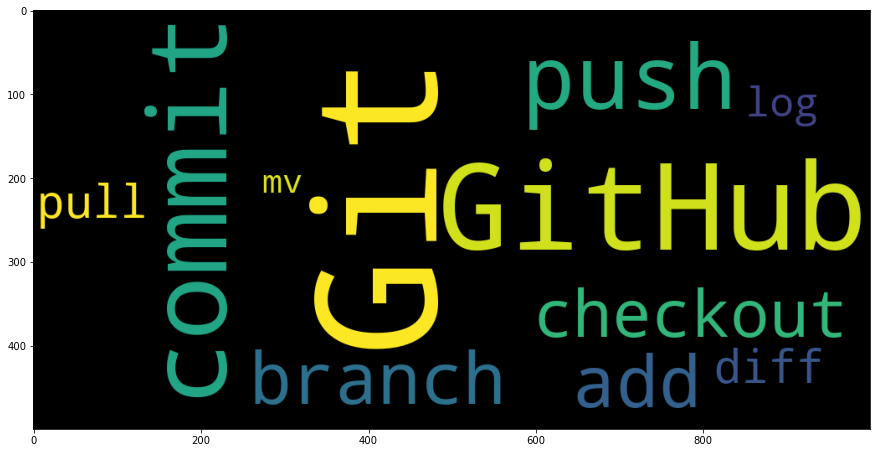

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_could_dict = {'Git':100, 'GitHub':100, 'push':50, 'pull':10, 'commit':80, 'add':30, 'diff':10, 
                  'mv':5, 'log':8, 'branch':30, 'checkout':25}

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

Build the frequency dictionary for positive and negative words in tweets ( positive means target value is 1 and negative means 0 )

In [29]:
X_input_tweets = df_train['text']
X_test_tweets = df_test['text']
y_input = df_train['target']
freqs, pos_word_freqs, neg_word_freqs = build_freqs(X_input_tweets, y_input)

In [30]:
def extract_features(tweet, freqs):
    tweet_words = process_tweet(tweet)
    # first column is bias, second positive word count, third negative word count
    feature_vector = np.zeros((1, 3))
    feature_vector[0, 0] = 1
    for word in tweet_words:
        feature_vector[0, 1] += freqs.get((word, 1.0), 0)
        feature_vector[0, 2] += freqs.get((word, 0.0), 0)
    return feature_vector

In [31]:
test_features = extract_features(X_input_tweets[0], freqs)
test_features

array([[  1., 149., 141.]])

In [32]:
X_input = np.zeros((len(X_train_tweets), 3))
X_test = np.zeros((len(X_test_tweets), 3))
for i, tweet in enumerate(X_train_tweets):
    X_input[i, :] = extract_features(tweet, freqs)
for i, tweet in enumerate(X_test_tweets):
    X_test[i, :] = extract_features(tweet, freqs)

print(X_input.shape)
print(X_test.shape)

(7613, 3)
(3263, 3)


Split training data into 80% training set and 20% validation set

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_input, y_input, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6090, 3), (1523, 3), (6090,), (1523,))

In [51]:
from sklearn.naive_bayes import ComplementNB
mnb = ComplementNB(alpha=1)
mnb.fit(X_train, y_train.ravel())

ComplementNB(alpha=1)

In [52]:
mnb.score(X_val, y_val)

0.7708470124753776

In [53]:
y_val_pred = mnb.predict(X_val)


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       874
           1       0.73      0.73      0.73       649

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



In [55]:
y_test_pred = mnb.predict(X_test)
df_test['target'] = y_test_pred
df_test.head(20)

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
5,12,NaN,NaN,We're shaking...It's an earthquake,1
6,21,NaN,NaN,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",0
7,22,NaN,NaN,Hey! How are you?,0
8,27,NaN,NaN,What a nice hat?,0
9,29,NaN,NaN,Fuck off!,0


In [59]:
df_submit = df_test[['id', 'target']]
df_submit.to_csv('results.csv')

In [60]:
import os

os.getcwd()

'/kaggle/working'